In [34]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor, XGBRFRegressor
import warnings

warnings.filterwarnings('ignore')


In [35]:
# --- Data Loading & Cleaning ---
data = pd.read_csv('bhd.csv')
data.drop('society', axis=1, inplace=True)
data['total_sqft'] = pd.to_numeric(data['total_sqft'], errors='coerce')
data.dropna(subset=['total_sqft', 'bath', 'location'], inplace=True)
data['total_sqft'] = data['total_sqft'].astype(int)

# --- Feature Selection ---
X = data.drop("price", axis=1)
y = data["price"]

categorical_cols = ["area_type", "availability", "location", "size"]
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# --- Preprocessing Pipelines ---
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [36]:
data

,area_type,availability,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,3453,4.0,0.0,231.00
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,3600,5.0,NaN,400.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,4689,4.0,1.0,488.00


In [37]:
data.sort_values(by='price', axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

In [38]:
max = data['price'].max()
min = data['price'].min()
avrg = (max+min)/2

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# --- Model Definitions ---
models = {
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, subsample=0.8, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, reg_lambda=1, reg_alpha=1, random_state=42),
}

In [41]:
# # --- Model Training & Evaluation ---
# results = []

# for name, model in models.items():
#     pipeline = Pipeline([
#         ("preprocessor", preprocessor),
#         ("regressor", model)
#     ])
#     pipeline.fit(X_train, y_train)
#     y_pred = pipeline.predict(X_test)
#     train_score = pipeline.score(X_train, y_train)
#     test_score = pipeline.score(X_test, y_test)
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
#     cv_score = cross_val_score(pipeline, X, y, cv=5, scoring='r2').mean()
#     results.append({
#         "Model": name,
#         "Train R2": train_score,
#         "Test R2": test_score,
#         "Test MSE": mse,
#         "CV R2": cv_score
#     })
#     print(f"{name} | Train R2: {train_score:.3f} | Test R2: {test_score:.3f} | Test MSE: {mse:.2f} | CV R2: {cv_score:.3f}")

# # --- Results DataFrame ---
# results_df = pd.DataFrame(results)
# print("\nSummary of Model Performance:")
# display(results_df.sort_values(by="Test R2", ascending=False))

In [42]:
top_location = data['size'].value_counts().nlargest(10)
top_availb =  data['availability'].value_counts().nlargest(2).index
data['availability'] = data['availability'].apply(lambda x: x if x in top_availb else 'Not Yet Ready')

In [43]:
data['size'] = data['size'].str.extract('(\d)').astype(float)

In [44]:
data['balcony'] = data['balcony'].fillna(data['balcony'].mean())

In [45]:
data['location'] = data['location'].apply(lambda x: x.strip())
location_stats =  data.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats_less_than_10 = location_stats[location_stats<10]
data.location = data['location'].apply(
    lambda x: 'Other location' 
    if x in location_stats_less_than_10 else x)

len(data['location'].unique())

255

In [46]:
data1 = data.copy()
data1['price_per_sqft'] = data1['price']*10000 / data1['total_sqft']

data1['location'] = data1['location'].apply(lambda x: x.strip())
location_stats =  data1.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats_less_than_10 = location_stats[location_stats<10]

In [47]:
#Removing some outliers using domain knoledge
data2 = data1[~((data1['total_sqft']/data1['size'])<300)]
data2.shape

(12328, 9)

In [48]:
def remove_price_per_sq_outliers(dataframe):
    df_out = pd.DataFrame()
    for key, sub_df in dataframe.groupby('location'):
        m = np.mean(sub_df['price_per_sqft'])
        st = np.std(sub_df['price_per_sqft'])
        reduced_df = sub_df[(sub_df['price_per_sqft']>(m-st)) & (sub_df['price_per_sqft']<=(m+st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out
data3 = remove_price_per_sq_outliers(data2)
data3.shape

(10138, 9)

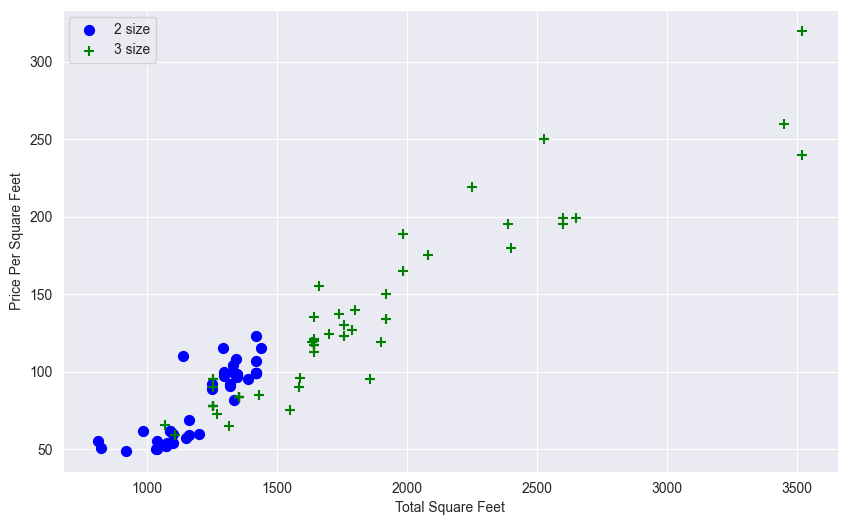

In [62]:
def plot_scatter_chart(dataframe, location):
    size2 = dataframe[(dataframe['location'] == location) & (dataframe['size'] == 2)]
    size3 = dataframe[(dataframe['location'] == location) & (dataframe['size'] == 3)]
    plt.figure(figsize=(10,6))
    plt.scatter(size2.total_sqft, size2.price, color='blue', label='2 size', s=50)
    plt.scatter(size3.total_sqft, size3.price, color='green', marker='+', label='3 size', s=50)
    plt.xlabel('Total Square Feet')
    plt.ylabel('Price Per Square Feet')
    plt.legend()
plot_scatter_chart(data3, 'Hebbal')

In [63]:
def remove_bedroom_outliers(dataframe):
    exclude_indices = np.array([])
    for location, df_location in dataframe.groupby('location'):
        bedroom_stat = {}
        for bedroom, df_bedroom in df_location.groupby('size'):
            bedroom_stat[bedroom] = {
                'mean': np.mean(df_bedroom['price_per_sqft']),
                'std': np.std(df_bedroom['price_per_sqft']),
                'count': df_bedroom.shape[0]
            }
        for bedroom, df_bedroom in df_location.groupby('size'):
            stats = bedroom_stat.get(bedroom-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, df_bedroom[df_bedroom['price_per_sqft']<(stats['mean'])].index.values)
    return dataframe.drop(exclude_indices, axis = 'index')

data4 = remove_bedroom_outliers(data3)
data4.shape

(7236, 9)

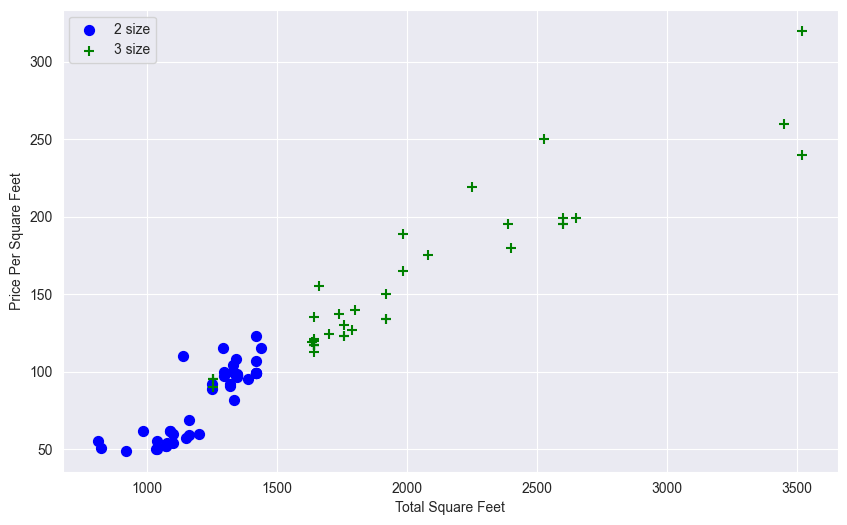

In [64]:
plot_scatter_chart(data4, 'Hebbal')

In [53]:
#Removing Outliers of Bathroom Greater Than Bedroom + 2 in Our Data Set
data5 = data4[~(data4['bath']>(data4['size'] + 2))]
data5.shape

(7220, 9)

In [57]:
data5.groupby('location')['location'].agg('count').sort_values(ascending=False)

location
Other location           1064
Whitefield                213
Sarjapur  Road            190
Electronic City           162
Raja Rajeshwari Nagar     140
                         ... 
ITPL                        4
Thyagaraja Nagar            4
Vishveshwarya Layout        4
Marsur                      3
BTM 1st Stage               2
Name: location, Length: 255, dtype: int64

In [54]:
data6 = data5.drop('price_per_sqft', axis=1)
data6.head(5)

,area_type,availability,location,size,total_sqft,bath,balcony,price
0,Built-up Area,Not Yet Ready,1st Block Jayanagar,3.0,1200,2.0,0.0,130.0
1,Super built-up Area,Not Yet Ready,1st Block Jayanagar,2.0,1235,2.0,2.0,148.0
2,Super built-up Area,Not Yet Ready,1st Block Jayanagar,3.0,1630,3.0,2.0,194.0
3,Super built-up Area,Ready To Move,1st Block Jayanagar,3.0,1875,2.0,3.0,235.0
4,Super built-up Area,Not Yet Ready,1st Block Jayanagar,4.0,2450,4.0,2.0,368.0


In [65]:
data6 = pd.get_dummies(data6, columns=['area_type', 'availability', 'location'], drop_first=False).astype(int)
data6
# ord = OrdinalEncoder()
# data6[['area_type', 'availability', 'location']]  = ord.fit_transform(data6[['area_type', 'availability', 'location']])

KeyError: "None of [Index(['area_type', 'availability', 'location'], dtype='object')] are in the [columns]"

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

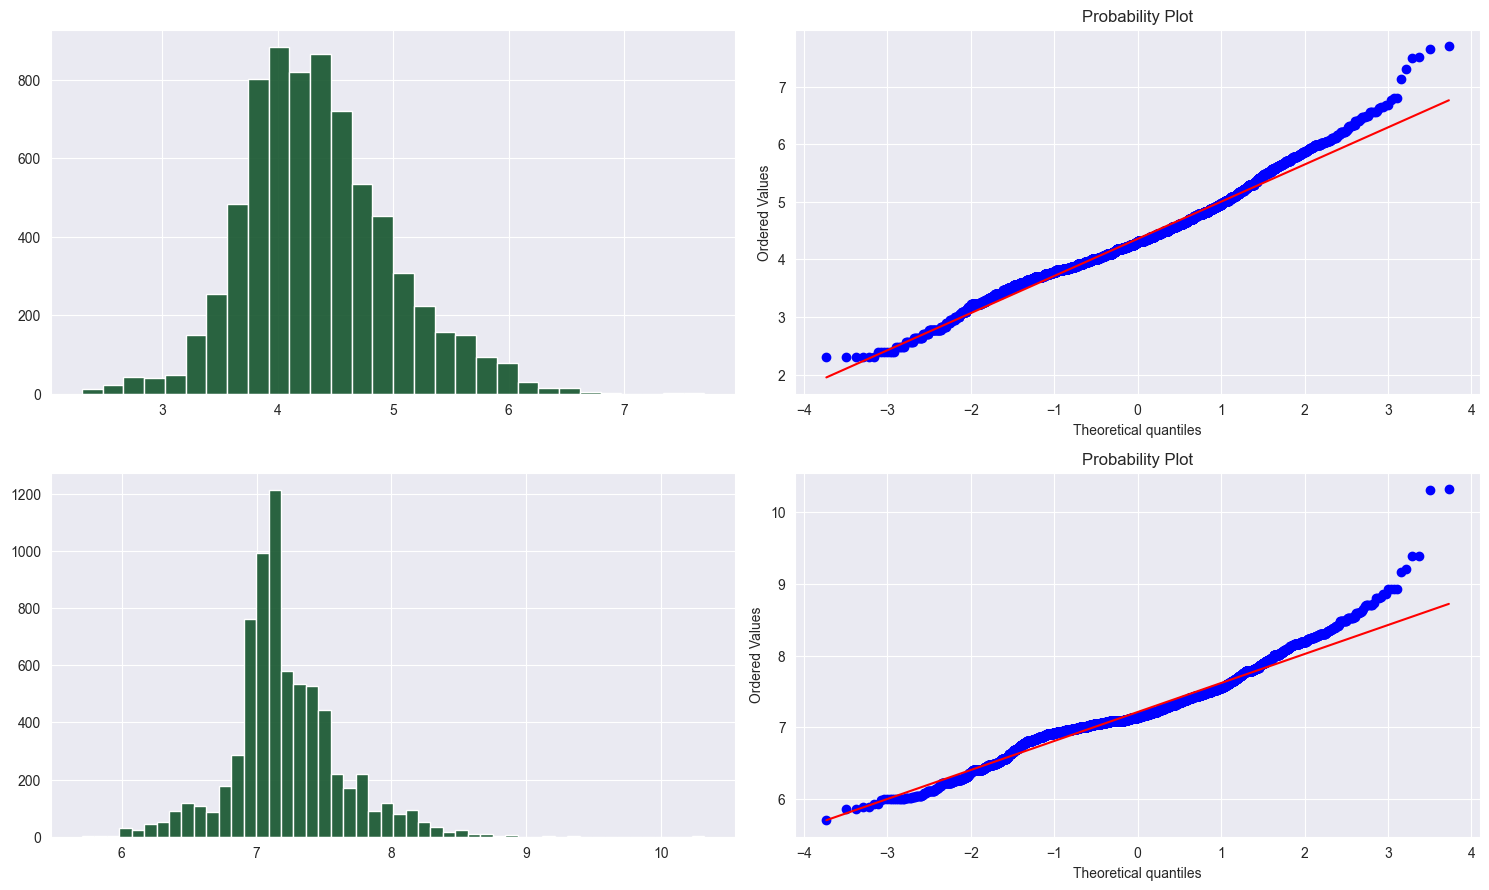

In [66]:
sns.set_style('darkgrid')
plt.figure(figsize=(15,13))
plt.subplot(3,2,1)
plt.hist(np.log(data6.price), color="#15552de7", bins=30, align='mid')
plt.subplot(3,2,2)
stats.probplot(np.log(data6.price), dist='norm', plot=plt)
plt.subplot(3,2,3)
plt.hist(np.log(data6.total_sqft), color="#15552de7", bins=50, align='mid')
plt.subplot(3,2,4)
stats.probplot(np.log(data6.total_sqft), dist='norm', plot=plt)
plt.tight_layout()
plt.show()

In [67]:
data6['_price'] = np.log(data6.price)
data6['_total'] = np.log(data6.total_sqft)

In [68]:
data6['z_score_1'] = (data6._price - data6['_price'].mean())/data6['_price'].std()
data6['z_score_2'] = (data6._total - data6['_total'].mean())/data6['_total'].std()

In [69]:
df_outliers0 = data6[(data6['z_score_1']<3)&(data6['z_score_1']>-3)]
df_outliers2  = df_outliers0[(df_outliers0['z_score_2']<3)&(df_outliers0['z_score_2']>-3)]
df_outliers2.drop(['z_score_1', 'z_score_2', 'total_sqft', 'price'], axis=1, inplace=True)

In [71]:
X = df_outliers2.drop("_price", axis=1)
y = df_outliers2["_price"]

In [72]:
# X.drop(['availability', 'bath', 'balcony'], axis=1, inplace=True)

In [73]:
scl = StandardScaler()
X = scl.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
try:
    model = XGBRegressor(n_estimators=200, learning_rate=0.2, max_depth=5, subsample=0.8, colsample_bytree=0.8, reg_lambda=1, reg_alpha=1, random_state=42)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
except Exception as e:
    print(e)

In [96]:
from sklearn.metrics import r2_score
try:
    print(f"Training Data Score:{model.score(X_train,y_train)*100:.2f}%")
    print(f"Testting Data Score:{model.score(X_test,y_test)*100:.2f}%")
    print(f"Available Error:{mean_squared_error(y_pred, y_test):.2f}%")
    print(f"Performance Score:{r2_score(y_pred,y_test)*100:.2f}%")
except Exception as e:
    print(e)

Training Data Score:89.80%
Testting Data Score:86.08%
Available Error:0.05%
Performance Score:84.21%


In [98]:
from sklearn.ensemble import BaggingRegressor
model11 = BaggingRegressor(estimator=XGBRFRegressor(), n_estimators=200, random_state=42, oob_score=True)
model11.fit(X_train, y_train)

BaggingRegressor(estimator=XGBRFRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          max_bin=None, max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          objective='reg:squarederror',
                                          random_state=None, ...),
                 n_estimators=200, oob_score=True, random_state=42)

In [99]:
model11.oob_score_

0.82191013298534

<center><h1></h1>ALHAMDULILLAH!!!</center>